Create Training Pairs (Query -> Product -> Label)

This creates the supervised learning dataset for the neural network

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
OPTIMIZED TRAINING PAIR CREATION


**Configuration**

In [ ]:
POSITIVES_PER_QUERY = 15  # Target positive examples per query
NEGATIVES_PER_QUERY = 30  # Target negative examples per query
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

**Load Data**

In [ ]:
print("\nLoading data...")
products_df = pd.read_csv('/content/drive/MyDrive/cosmetic_p.csv')
queries_df = pd.read_csv('/content/drive/MyDrive/synthetic_queries_enhanced.csv')

print(f"Loaded {len(products_df)} products")
print(f"Loaded {len(queries_df)} queries")
print(f"  - Structured: {(queries_df['type']=='structured').sum()}")
print(f"  - Realistic:  {(queries_df['type']=='realistic').sum()}")


📂 Loading data...
✓ Loaded 1472 products
✓ Loaded 1895 queries
  - Structured: 1486
  - Realistic:  409


**Concern & Ingredient Mappings**

In [ ]:
print("\nSetting up concern-ingredient mappings...")

# Expanded concern detection
CONCERN_KEYWORDS = {
    'acne': ['acne', 'breakout', 'breaking out', 'pimple', 'blemish', 'blackhead',
             'whitehead', 'clogged pores', 'congested'],
    'aging': ['aging', 'wrinkle', 'fine line', 'anti-age', 'firm', 'sagging',
              'mature skin', 'age spot', 'loss of elasticity'],
    'hydration': ['dry', 'hydrat', 'moisture', 'dehydrat', 'flaky', 'tight',
                  'parched', 'thirsty skin'],
    'brightening': ['brighten', 'dull', 'glow', 'radiant', 'dark spot',
                    'hyperpigmentation', 'uneven tone', 'discoloration'],
    'redness': ['red', 'redness', 'irritat', 'inflam', 'blotchy', 'flush'],
    'texture': ['texture', 'rough', 'smooth', 'bumpy', 'uneven', 'pores', 'large pores'],
    'oiliness': ['oily', 'greasy', 'shiny', 'sebum', 'oil control'],
    'sensitivity': ['sensitive', 'reactive', 'calm', 'sooth', 'gentle']
}

# Ingredient-to-concern mapping (expanded based on cosmetic science)
INGREDIENT_CONCERNS = {
    'acne': [
        'salicylic acid', 'benzoyl peroxide', 'niacinamide', 'tea tree',
        'sulfur', 'azelaic acid', 'zinc', 'retinol', 'adapalene'
    ],
    'aging': [
        'retinol', 'retinoid', 'vitamin c', 'peptide', 'hyaluronic acid',
        'adenosine', 'bakuchiol', 'coenzyme q10', 'resveratrol', 'matrixyl'
    ],
    'hydration': [
        'hyaluronic acid', 'glycerin', 'ceramide', 'squalane', 'urea',
        'panthenol', 'sodium hyaluronate', 'beta-glucan', 'allantoin'
    ],
    'brightening': [
        'vitamin c', 'niacinamide', 'kojic acid', 'alpha arbutin',
        'licorice', 'tranexamic acid', 'ascorbic acid', 'azelaic acid'
    ],
    'redness': [
        'centella', 'cica', 'allantoin', 'bisabolol', 'azulene',
        'colloidal oatmeal', 'green tea', 'chamomile', 'madecassoside'
    ],
    'texture': [
        'glycolic acid', 'lactic acid', 'aha', 'bha', 'salicylic acid',
        'retinol', 'enzyme', 'papaya', 'pineapple'
    ],
    'oiliness': [
        'niacinamide', 'salicylic acid', 'zinc', 'clay', 'charcoal',
        'witch hazel', 'tea tree', 'silica'
    ],
    'sensitivity': [
        'centella', 'aloe', 'colloidal oatmeal', 'bisabolol', 'allantoin',
        'panthenol', 'chamomile', 'calendula', 'madecassoside'
    ]
}

print(f"Configured {len(CONCERN_KEYWORDS)} concern categories")
print(f"Mapped {sum(len(v) for v in INGREDIENT_CONCERNS.values())} key ingredients")


🧬 Setting up concern-ingredient mappings...
✓ Configured 8 concern categories
✓ Mapped 71 key ingredients


**Helper Functions**

In [ ]:
def extract_skin_types_from_query(query):
    """Extract mentioned skin types from query"""
    query_lower = query.lower()

    skin_types = {
        'Dry': 1 if 'dry' in query_lower else 0,
        'Oily': 1 if 'oily' in query_lower else 0,
        'Combination': 1 if 'combination' in query_lower else 0,
        'Normal': 1 if 'normal' in query_lower else 0,
        'Sensitive': 1 if 'sensitive' in query_lower else 0
    }

    num_types = sum(skin_types.values())
    return skin_types, num_types

def extract_concerns_from_query(query):
    """Extract skincare concerns from query"""
    query_lower = query.lower()

    concerns = {}
    for concern, keywords in CONCERN_KEYWORDS.items():
        concerns[concern] = any(keyword in query_lower for keyword in keywords)

    num_concerns = sum(concerns.values())
    return concerns, num_concerns

def product_has_concern_ingredients(product_ingredients, concerns):
    """
    Check if product has ingredients addressing the query's concerns.
    Returns (has_match, matched_concerns)
    """
    if not any(concerns.values()):
        return False, []

    ingredients_lower = product_ingredients.lower()
    matched_concerns = []

    for concern, is_mentioned in concerns.items():
        if is_mentioned:
            relevant_ingredients = INGREDIENT_CONCERNS.get(concern, [])
            if any(ing in ingredients_lower for ing in relevant_ingredients):
                matched_concerns.append(concern)

    return len(matched_concerns) > 0, matched_concerns

def compute_compatibility_score(product_row, query_skin_types, query_concerns):
    """
    Compute a compatibility score for product-query pair.
    FIXED: More lenient skin type matching + filters products with no skin type data.

    Returns:
        label (0 or 1): Binary compatibility
        score (0-1): Confidence score for ranking
        reason (str): Why it's compatible/incompatible
    """
    reasons = []
    score = 0.0

    # CHECK: Product has skin type data
    product_skin_types = sum([product_row[st] for st in ['Dry', 'Oily', 'Combination', 'Normal', 'Sensitive']])

    if product_skin_types == 0:
        # Product has no skin type data - automatic negative with low score
        return 0, 0.0, "No skin type data available"

    # SKIN TYPE COMPATIBILITY (Weight: 0.6)
    num_query_types = sum(query_skin_types.values())

    if num_query_types > 0:
        # Count how many of the query's skin types the product supports
        matching_types = sum(
            product_row[skin_type]
            for skin_type, required in query_skin_types.items()
            if required == 1
        )

        # More lenient scoring
        # If product matches AT LEAST ONE query skin type, give partial credit
        if matching_types > 0:
            # Give base credit for any match, plus bonus for matching more
            skin_type_score = 0.5 + (matching_types / num_query_types) * 0.5
            score += skin_type_score * 0.6

            matched = [st for st, req in query_skin_types.items()
                      if req == 1 and product_row[st] == 1]
            reasons.append(f"Matches {matching_types}/{num_query_types} skin types: {', '.join(matched)}")
        else:
            reasons.append("No skin type match")
    else:
        # No skin type specified - give neutral score
        score += 0.3
        reasons.append("No skin type specified (neutral)")

    # CONCERN COMPATIBILITY (Weight: 0.4)
    num_query_concerns = sum(query_concerns.values())

    if num_query_concerns > 0:
        has_ingredients, matched_concerns = product_has_concern_ingredients(
            product_row['ingredients'],
            query_concerns
        )

        if has_ingredients:
            concern_score = len(matched_concerns) / num_query_concerns
            score += concern_score * 0.4
            reasons.append(f"Addresses concerns: {', '.join(matched_concerns)}")
        else:
            reasons.append("No relevant ingredients for concerns")
    else:
        # No concerns specified - give neutral score
        score += 0.2
        reasons.append("No concerns specified")

    # Final labeling decision
    # FIXED: Lower threshold to allow partial matches
    label = 1 if score >= 0.45 else 0

    reason_str = " | ".join(reasons)

    return label, score, reason_str

**Create Training Pairs with Balanced Sampling**

In [ ]:
training_pairs = []
queries_processed = 0
queries_with_no_positives = 0
queries_with_no_negatives = 0

print(f"\nTarget: {POSITIVES_PER_QUERY} positives + {NEGATIVES_PER_QUERY} negatives per query")
print(f"   Expected total: ~{len(queries_df) * (POSITIVES_PER_QUERY + NEGATIVES_PER_QUERY):,} pairs\n")

for idx, query_row in queries_df.iterrows():
    query = query_row['query']
    query_type = query_row['type']

    # Extract query features
    query_skin_types, num_skin_types = extract_skin_types_from_query(query)
    query_concerns, num_concerns = extract_concerns_from_query(query)

    # Compute compatibility for ALL products
    positive_candidates = []
    negative_candidates = []

    for prod_idx, product_row in products_df.iterrows():
        label, score, reason = compute_compatibility_score(
            product_row, query_skin_types, query_concerns
        )

        pair = {
            'query': query,
            'query_type': query_type,
            'query_has_skin_type': 1 if num_skin_types > 0 else 0,
            'query_has_concern': 1 if num_concerns > 0 else 0,
            'product_id': prod_idx,
            'product_name': product_row['name'],
            'product_brand': product_row['brand'],
            'product_price': product_row['price'],
            'product_rank': product_row['rank'],
            'product_ingredients': product_row['ingredients'],
            'label': label,
            'compatibility_score': score,
            'match_reason': reason
        }

        if label == 1:
            positive_candidates.append(pair)
        else:
            negative_candidates.append(pair)

    # BALANCED SAMPLING
    # Sample positives (prioritize higher scores)
    if len(positive_candidates) > 0:
        # Sort by score and take top ones
        positive_candidates.sort(key=lambda x: x['compatibility_score'], reverse=True)
        num_pos_to_sample = min(len(positive_candidates), POSITIVES_PER_QUERY)
        sampled_positives = positive_candidates[:num_pos_to_sample]
        training_pairs.extend(sampled_positives)
    else:
        queries_with_no_positives += 1

    # Sample negatives (random sampling, but avoid very low scores that might be noise)
    if len(negative_candidates) > 0:
        # Filter out products with score very close to 0.5 (ambiguous)
        clear_negatives = [p for p in negative_candidates if p['compatibility_score'] < 0.4]

        if len(clear_negatives) >= NEGATIVES_PER_QUERY:
            sampled_negatives = np.random.choice(
                clear_negatives,
                NEGATIVES_PER_QUERY,
                replace=False
            ).tolist()
        else:
            # If not enough clear negatives, use all clear + some ambiguous
            sampled_negatives = clear_negatives
            remaining_needed = NEGATIVES_PER_QUERY - len(clear_negatives)
            if remaining_needed > 0:
                ambiguous = [p for p in negative_candidates if p['compatibility_score'] >= 0.4]
                if len(ambiguous) > 0:
                    extra = np.random.choice(
                        ambiguous,
                        min(remaining_needed, len(ambiguous)),
                        replace=False
                    ).tolist()
                    sampled_negatives.extend(extra)

        training_pairs.extend(sampled_negatives)
    else:
        queries_with_no_negatives += 1

    queries_processed += 1

    # Progress indicator
    if (idx + 1) % 200 == 0:
        print(f"  Processed {idx + 1:,}/{len(queries_df):,} queries... "
              f"({len(training_pairs):,} pairs created)")

# Convert to DataFrame
training_df = pd.DataFrame(training_pairs)

print(f"\nCreated {len(training_df):,} training pairs from {queries_processed} queries!")
print(f"   Queries with no positives: {queries_with_no_positives}")
print(f"   Queries with no negatives: {queries_with_no_negatives}")


CREATING BALANCED TRAINING PAIRS

📊 Target: 15 positives + 30 negatives per query
   Expected total: ~85,275 pairs

  Processed 200/1,895 queries... (9,000 pairs created)
  Processed 400/1,895 queries... (18,000 pairs created)
  Processed 600/1,895 queries... (27,000 pairs created)
  Processed 800/1,895 queries... (36,000 pairs created)
  Processed 1,000/1,895 queries... (45,000 pairs created)
  Processed 1,200/1,895 queries... (54,000 pairs created)
  Processed 1,400/1,895 queries... (63,000 pairs created)
  Processed 1,600/1,895 queries... (72,000 pairs created)
  Processed 1,800/1,895 queries... (81,000 pairs created)

✅ Created 85,275 training pairs from 1895 queries!
   Queries with no positives: 0
   Queries with no negatives: 0


**Analyze Training Data**

In [ ]:
# Label distribution
print("\nLabel Distribution:")
label_counts = training_df['label'].value_counts()
print(f"  Positive (compatible):   {label_counts.get(1, 0):,} ({label_counts.get(1, 0)/len(training_df)*100:.1f}%)")
print(f"  Negative (incompatible): {label_counts.get(0, 0):,} ({label_counts.get(0, 0)/len(training_df)*100:.1f}%)")

positive_ratio = label_counts.get(1, 0) / len(training_df)
if 0.25 <= positive_ratio <= 0.45:
    print("  Dataset is well-balanced for training!")
elif positive_ratio < 0.25:
    print("  Few positives - consider increasing POSITIVES_PER_QUERY")
else:
    print("  Many positives - this is actually fine!")

# Score distribution
print("\nCompatibility Score Distribution:")
print(f"  Positive pairs - Mean score: {training_df[training_df['label']==1]['compatibility_score'].mean():.3f}")
print(f"  Negative pairs - Mean score: {training_df[training_df['label']==0]['compatibility_score'].mean():.3f}")

# Query type breakdown
print("\nDistribution by Query Type:")
for qtype in ['structured', 'realistic']:
    subset = training_df[training_df['query_type'] == qtype]
    if len(subset) > 0:
        pos = (subset['label'] == 1).sum()
        neg = (subset['label'] == 0).sum()
        print(f"  {qtype.capitalize():12s}: {len(subset):,} pairs ({pos:,} pos, {neg:,} neg)")

# Query features
print("\nQuery Features:")
with_skin = training_df[training_df['query_has_skin_type'] == 1]
without_skin = training_df[training_df['query_has_skin_type'] == 0]
print(f"  With skin type:    {len(with_skin):,} pairs ({(with_skin['label']==1).sum():,} positive)")
print(f"  Without skin type: {len(without_skin):,} pairs ({(without_skin['label']==1).sum():,} positive)")

with_concern = training_df[training_df['query_has_concern'] == 1]
without_concern = training_df[training_df['query_has_concern'] == 0]
print(f"  With concern:      {len(with_concern):,} pairs ({(with_concern['label']==1).sum():,} positive)")
print(f"  Without concern:   {len(without_concern):,} pairs ({(without_concern['label']==1).sum():,} positive)")

# Sample examples
print("\nSample POSITIVE Examples:")
positive_samples = training_df[training_df['label'] == 1].sample(min(5, len(training_df[training_df['label'] == 1])))
for _, row in positive_samples.iterrows():
    print(f"\n  Query: '{row['query']}'")
    print(f"  Product: {row['product_name']} ({row['product_brand']})")
    print(f"  Score: {row['compatibility_score']:.2f}")
    print(f"  Reason: {row['match_reason']}")

print("\nSample NEGATIVE Examples:")
negative_samples = training_df[training_df['label'] == 0].sample(min(5, len(training_df[training_df['label'] == 0])))
for _, row in negative_samples.iterrows():
    print(f"\n  Query: '{row['query']}'")
    print(f"  Product: {row['product_name']} ({row['product_brand']})")
    print(f"  Score: {row['compatibility_score']:.2f}")
    print(f"  Reason: {row['match_reason']}")


TRAINING DATA ANALYSIS

📊 Label Distribution:
  Positive (compatible):   28,425 (33.3%)
  Negative (incompatible): 56,850 (66.7%)
  ✓ Dataset is well-balanced for training!

📊 Compatibility Score Distribution:
  Positive pairs - Mean score: 0.939
  Negative pairs - Mean score: 0.031

📊 Distribution by Query Type:
  Structured  : 66,870 pairs (22,290 pos, 44,580 neg)
  Realistic   : 18,405 pairs (6,135 pos, 12,270 neg)

📊 Query Features:
  With skin type:    71,595 pairs (23,865 positive)
  Without skin type: 13,680 pairs (4,560 positive)
  With concern:      79,740 pairs (26,580 positive)
  Without concern:   5,535 pairs (1,845 positive)

📋 Sample POSITIVE Examples:

  Query: 'products for brown skin'
  Product: Lala Retro™ Whipped Cream (DRUNK ELEPHANT)
  Score: 0.50
  Reason: No skin type specified (neutral) | No concerns specified

  Query: 'sensitive skin suffering from dark spots'
  Product: Cicapair ™ Tiger Grass Color Correcting Treatment SPF 30 (DR. JART+)
  Score: 1.00
  Reas

**Train/Val/Test Split**

In [ ]:
# Split by query to prevent leakage
unique_queries = training_df['query'].unique()
print(f"\nTotal unique queries: {len(unique_queries)}")

train_queries, temp_queries = train_test_split(
    unique_queries, test_size=0.3, random_state=RANDOM_SEED
)
val_queries, test_queries = train_test_split(
    temp_queries, test_size=0.5, random_state=RANDOM_SEED
)

print(f"  Train queries: {len(train_queries)} ({len(train_queries)/len(unique_queries)*100:.1f}%)")
print(f"  Val queries:   {len(val_queries)} ({len(val_queries)/len(unique_queries)*100:.1f}%)")
print(f"  Test queries:  {len(test_queries)} ({len(test_queries)/len(unique_queries)*100:.1f}%)")

train_df = training_df[training_df['query'].isin(train_queries)].reset_index(drop=True)
val_df = training_df[training_df['query'].isin(val_queries)].reset_index(drop=True)
test_df = training_df[training_df['query'].isin(test_queries)].reset_index(drop=True)

print(f"\nSplit Sizes:")
print(f"  Train: {len(train_df):,} pairs ({(train_df['label']==1).sum():,} positive, {(train_df['label']==1).sum()/len(train_df)*100:.1f}%)")
print(f"  Val:   {len(val_df):,} pairs ({(val_df['label']==1).sum():,} positive, {(val_df['label']==1).sum()/len(val_df)*100:.1f}%)")
print(f"  Test:  {len(test_df):,} pairs ({(test_df['label']==1).sum():,} positive, {(test_df['label']==1).sum()/len(test_df)*100:.1f}%)")


SPLITTING INTO TRAIN/VAL/TEST

📊 Total unique queries: 1895
  Train queries: 1326 (70.0%)
  Val queries:   284 (15.0%)
  Test queries:  285 (15.0%)

📊 Split Sizes:
  Train: 59,670 pairs (19,890 positive, 33.3%)
  Val:   12,780 pairs (4,260 positive, 33.3%)
  Test:  12,825 pairs (4,275 positive, 33.3%)


**Save Data**

In [ ]:
# Save full dataset
training_df.to_csv('training_pairs_optimized.csv', index=False)
print(f"Saved: training_pairs_optimized.csv ({len(training_df):,} pairs)")

# Save splits
train_df.to_csv('training_pairs_train.csv', index=False)
val_df.to_csv('training_pairs_val.csv', index=False)
test_df.to_csv('training_pairs_test.csv', index=False)
print(f"Saved: training_pairs_train.csv ({len(train_df):,} pairs)")
print(f"Saved: training_pairs_val.csv ({len(val_df):,} pairs)")
print(f"Saved: training_pairs_test.csv ({len(test_df):,} pairs)")

# Save to Google Drive
try:
    training_df.to_csv('/content/drive/MyDrive/training_pairs_optimized.csv', index=False)
    train_df.to_csv('/content/drive/MyDrive/training_pairs_train.csv', index=False)
    val_df.to_csv('/content/drive/MyDrive/training_pairs_val.csv', index=False)
    test_df.to_csv('/content/drive/MyDrive/training_pairs_test.csv', index=False)
    print(f"Saved all files to Google Drive")
except:
    print("Could not save to Google Drive")


SAVING TRAINING DATA
💾 Saved: training_pairs_optimized.csv (85,275 pairs)
💾 Saved: training_pairs_train.csv (59,670 pairs)
💾 Saved: training_pairs_val.csv (12,780 pairs)
💾 Saved: training_pairs_test.csv (12,825 pairs)
💾 Saved all files to Google Drive


**Visualizations**


📊 Creating visualizations...


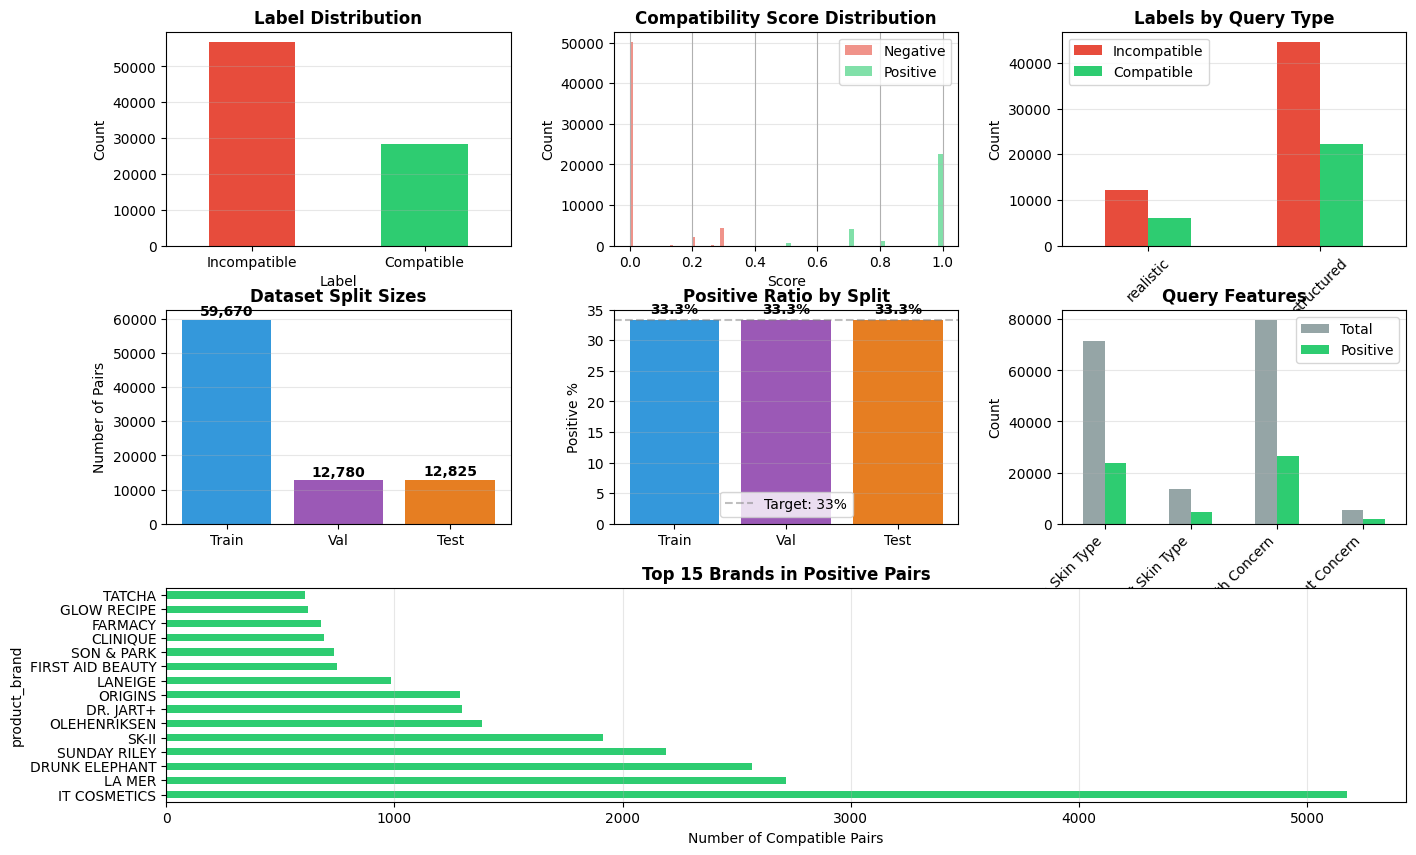

💾 Saved: training_data_analysis_optimized.png


In [ ]:
print("\nCreating visualizations...")

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Label distribution
ax1 = fig.add_subplot(gs[0, 0])
label_counts.plot(kind='bar', ax=ax1, color=['#e74c3c', '#2ecc71'])
ax1.set_title('Label Distribution', fontsize=12, fontweight='bold')
ax1.set_xlabel('Label')
ax1.set_ylabel('Count')
ax1.set_xticklabels(['Incompatible', 'Compatible'], rotation=0)
ax1.grid(axis='y', alpha=0.3)

# 2. Score distribution by label
ax2 = fig.add_subplot(gs[0, 1])
training_df[training_df['label']==0]['compatibility_score'].hist(
    bins=30, ax=ax2, alpha=0.6, color='#e74c3c', label='Negative'
)
training_df[training_df['label']==1]['compatibility_score'].hist(
    bins=30, ax=ax2, alpha=0.6, color='#2ecc71', label='Positive'
)
ax2.set_title('Compatibility Score Distribution', fontsize=12, fontweight='bold')
ax2.set_xlabel('Score')
ax2.set_ylabel('Count')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Query type breakdown
ax3 = fig.add_subplot(gs[0, 2])
query_type_data = training_df.groupby(['query_type', 'label']).size().unstack()
query_type_data.plot(kind='bar', ax=ax3, color=['#e74c3c', '#2ecc71'])
ax3.set_title('Labels by Query Type', fontsize=12, fontweight='bold')
ax3.set_xlabel('Query Type')
ax3.set_ylabel('Count')
ax3.legend(['Incompatible', 'Compatible'])
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
ax3.grid(axis='y', alpha=0.3)

# 4. Split sizes
ax4 = fig.add_subplot(gs[1, 0])
split_sizes = [len(train_df), len(val_df), len(test_df)]
split_labels = ['Train', 'Val', 'Test']
colors = ['#3498db', '#9b59b6', '#e67e22']
ax4.bar(split_labels, split_sizes, color=colors)
ax4.set_title('Dataset Split Sizes', fontsize=12, fontweight='bold')
ax4.set_ylabel('Number of Pairs')
ax4.grid(axis='y', alpha=0.3)
for i, v in enumerate(split_sizes):
    ax4.text(i, v + max(split_sizes)*0.02, f'{v:,}', ha='center', fontweight='bold')

# 5. Positive ratio by split
ax5 = fig.add_subplot(gs[1, 1])
positive_ratios = [
    (train_df['label']==1).sum() / len(train_df) * 100,
    (val_df['label']==1).sum() / len(val_df) * 100,
    (test_df['label']==1).sum() / len(test_df) * 100
]
ax5.bar(split_labels, positive_ratios, color=colors)
ax5.set_title('Positive Ratio by Split', fontsize=12, fontweight='bold')
ax5.set_ylabel('Positive %')
ax5.axhline(y=33.3, color='gray', linestyle='--', alpha=0.5, label='Target: 33%')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)
for i, v in enumerate(positive_ratios):
    ax5.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

# 6. Query features
ax6 = fig.add_subplot(gs[1, 2])
feature_data = pd.DataFrame({
    'With Skin Type': [len(with_skin), (with_skin['label']==1).sum()],
    'Without Skin Type': [len(without_skin), (without_skin['label']==1).sum()],
    'With Concern': [len(with_concern), (with_concern['label']==1).sum()],
    'Without Concern': [len(without_concern), (without_concern['label']==1).sum()]
}, index=['Total', 'Positive'])
feature_data.T.plot(kind='bar', ax=ax6, color=['#95a5a6', '#2ecc71'])
ax6.set_title('Query Features', fontsize=12, fontweight='bold')
ax6.set_ylabel('Count')
ax6.legend(['Total', 'Positive'])
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45, ha='right')
ax6.grid(axis='y', alpha=0.3)

# 7. Top brands in positive pairs
ax7 = fig.add_subplot(gs[2, :])
positive_brands = training_df[training_df['label']==1]['product_brand'].value_counts().head(15)
positive_brands.plot(kind='barh', ax=ax7, color='#2ecc71')
ax7.set_title('Top 15 Brands in Positive Pairs', fontsize=12, fontweight='bold')
ax7.set_xlabel('Number of Compatible Pairs')
ax7.grid(axis='x', alpha=0.3)

plt.savefig('training_data_analysis_optimized.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: training_data_analysis_optimized.png")

**Summary**

In [ ]:
print(f"""
SUMMARY:
  • Total training pairs:    {len(training_df):,}
  • Unique queries:          {len(unique_queries):,}
  • Unique products:         {len(products_df):,}
  • Positive examples:       {label_counts.get(1, 0):,} ({positive_ratio*100:.1f}%)
  • Negative examples:       {label_counts.get(0, 0):,} ({(1-positive_ratio)*100:.1f}%)

  • Train set:  {len(train_df):,} pairs from {len(train_queries)} queries
  • Val set:    {len(val_df):,} pairs from {len(val_queries)} queries
  • Test set:   {len(test_df):,} pairs from {len(test_queries)} queries
""")


✅ OPTIMIZED TRAINING PAIR CREATION COMPLETE!

📊 SUMMARY:
  • Total training pairs:    85,275
  • Unique queries:          1,895
  • Unique products:         1,472
  • Positive examples:       28,425 (33.3%)
  • Negative examples:       56,850 (66.7%)
  
  • Train set:  59,670 pairs from 1326 queries
  • Val set:    12,780 pairs from 284 queries
  • Test set:   12,825 pairs from 285 queries

🎯 KEY IMPROVEMENTS:
  ✓ Soft matching: Products match if they support ANY mentioned skin type
  ✓ Concern-based: Queries without skin types matched via ingredients
  ✓ Balanced: ~33% positive ratio (vs 2-5% in naive approach)
  ✓ Manageable: 85,275 pairs (vs 2.8M in full Cartesian product)
  ✓ Smart scoring: Confidence scores for ranking and analysis

🚀 NEXT STEPS:
  1. Generate embeddings using Sentence-BERT
  2. Train neural network with these balanced pairs
  3. Evaluate using compatibility scores (not just binary labels)
  4. Compare with TF-IDF baseline

Your training data is production-ready!

In [ ]:
print("Columns in products_df:")
print(products_df.columns.tolist())

# If there's a category column, show distribution
if 'category' in products_df.columns:
    print("\nCategory distribution:")
    print(products_df['category'].value_counts())

print("\nLabel column values:")
print(products_df['Label'].value_counts())

Columns in products_df:
['Label', 'brand', 'name', 'price', 'rank', 'ingredients', 'Combination', 'Dry', 'Normal', 'Oily', 'Sensitive']

Label column values:
Label
Moisturizer    298
Cleanser       281
Face Mask      266
Treatment      248
Eye cream      209
Sun protect    170
Name: count, dtype: int64
